In [12]:
%matplotlib inline
import numpy as np
import qutip as qt

from matplotlib import pyplot as plt

# This loads the modestly named AndrewLib library, which is a collection of functions and constants
import andrewlib as alib 

# me being lazy
pi,tau = np.pi, 2*np.pi

## 2-Level Atom comparison

In [13]:
# QuTip Operators
g = qt.basis(2, 0);e = qt.basis(2, 1)  # define states

s11 = g * g.dag();s12 = g * e.dag()  # |g⟩⟨e|
s21 = e * g.dag();s22 = e * e.dag()  # |e⟩⟨e|

# Define Pulse at z=0
def Omega_input_2LA(Omega_max, t_list, tau_ramp=.10):
    """Rabi frequency at input face (z=0), dimensionless."""
    return Omega_max * (1 - np.exp(-t_list / tau_ramp))

# OBE solver
def solve_OBEs_2LA(Omega_in,Delta,t_list,rho0 = s11,Gamma = 1):    
    """Solve the optical Bloch equations for a given Rabi frequency Ω(z,t)."""
    H0 = -Delta * s22
    cops = [np.sqrt(Gamma) * s12]
    Omega_interp = lambda t, args: np.interp(t, t_list, Omega_in)
    Omega_interp_c = lambda t, args: np.interp(t, t_list, np.conj(Omega_in))
    H = [H0, [-s21/2, Omega_interp],[-s12/2, Omega_interp_c]] 
    result = qt.mesolve(H, rho0, t_list, c_ops = cops, e_ops = [s12])
    return result.expect[0]    

# MBE solver
def solve_MBEs_2LA(t_list,z_list,Omega_max, Delta = 0,Gamma = 1):
    Nz,Nt = len(z_list), len(t_list)
    dz = z_list[1]-z_list[0]
    Omega = np.zeros((Nz, Nt), dtype=complex)   # Rabi frequency Ω(z,t)
    rho12 = np.zeros((Nz, Nt), dtype=complex)   # Coherence ρ12(z,t)
    
    Omega[0, :] = Omega_input_2LA(Omega_max,t_list)
    for i in range(1, Nz):
        Omega_slice = Omega[i-1, :]  # Rabi frequency at previous z
        rho12[i-1, :] = solve_OBEs_2LA(Omega_slice, Delta, t_list)

        Omega[i, :] = Omega[i-1, :] + 1j * rho12[i-1, :]*dz
    # rho12[-1, :] = solve_OBEs_2LA(Omega[-1,:], t)
    return Omega[-1, :]


Text(0, 0.5, 'Intensity Transmission')

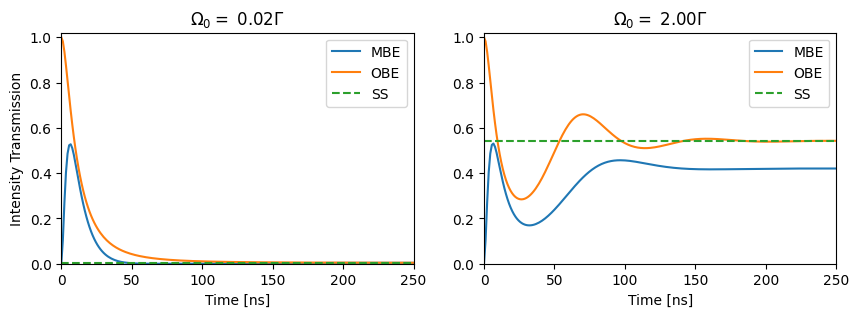

In [15]:
# -------------------------------
# Physical Parameters
# ------------------------------- 

GRb = alib.GammaRb
N = 3e16
PF = (N*alib.dRb**2)/(alib.hbar*alib.epsilon0)
L = 1e-3
k = tau / alib.lambdaRb87_D1

Gamma = 1
Delta = 0*1.5*Gamma
Omega_low = 0.02*Gamma
Omega_hi = 2.00*Gamma

# Non-dimensional parameters
eta = PF * (np.pi / alib.lambdaRb87_D1) / GRb  # Scaled coupling strength
L0 = 1/eta # Characteristic length scale (OD = 1 at z = L0)


# -------------------------------
# Initialization
# -------------------------------

# Define space-time grid
Nz = 100                  # Number of spatial steps
Nt = 250                  # Number of time steps

Z_max = L/L0  # Maximum length in dimensionless units
T_max = 10

rho0 = s11  # Initial state: all atoms in ground state

z = np.linspace(0, Z_max, Nz)
t = np.linspace(0, T_max, Nt)
dz = z[1] - z[0]
dt = t[1] - t[0]


# def solve_MBEs_2LA(t_list,z_list,Omega_max = 1, Delta = 0,Gamma = 1):
# Solve Maxwell-Bloch equations for given Ω0
transmission_lo = solve_MBEs_2LA(t,z,Omega_low)/Omega_low  
transmission_hi = solve_MBEs_2LA(t,z,Omega_hi)/Omega_hi

trns = [transmission_lo, transmission_hi]
omgs = [Omega_low, Omega_hi]
tns = t*1e9/GRb


fig, (ax_lo,ax_hi) = plt.subplots(1,2, figsize=(10, 3))

for i, ax in enumerate([ax_lo, ax_hi]):
    rho12 = solve_OBEs_2LA(Omega_input_2LA(omgs[i],t),Delta = 0, t_list = t)
    chi = PF*rho12/(omgs[i]*GRb)
    OD = np.imag(chi)*k*L            
    
    chi_ss = (PF/GRb)*(1j-2*Delta)/(1 + 4*Delta**2 + 2*omgs[i]**2)  # Steady state susceptibility
    OD_ss = np.imag(chi_ss) * L*k

    chi_swa = -(PF/GRb)/(2*Delta +1j)
    OD_swa = np.imag(chi_swa) * L*k

    ax.plot(tns, np.abs(trns[i])**2, label='MBE')
    ax.plot(tns, np.exp(-OD), label='OBE')
    ax.plot(tns, np.ones(len(tns))*np.exp(-OD_ss),'--', label='SS')
    # ax.plot(tns, np.ones(len(tns))*np.exp(-OD_swa),'-',color='gray', label='SWA',alpha=.3)
    ax.set_xlabel('Time [ns]')
    ax.set_xlim([0, 250])
    ax.set_ylim(0, 1.02)
    ax.set_title(f'$\\Omega_0 = $ {omgs[i]:.2f}$\\Gamma$')
    ax.legend(loc = 'upper right')


chi_ss_zm = (PF/GRb)*(1j-2*Delta)/(1 + 4*Delta**2 + 2*Omega_low**2)  # Steady state susceptibility
OD_ss_zm = np.imag(chi_ss_zm) * L*k


ax_lo.set_ylabel('Intensity Transmission')


# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# # 40% width/height of the parent axes, anchored at top-right
# axins = inset_axes(ax_lo, width="40%", height="40%", loc="center", borderpad=1.0)

# # plot into inset (same curves you used before)
# axins.plot(tns, np.abs(t_lo)**2)
# rho12_lo = solve_OBEs(Omega_input(t, Omega_low), t)
# chi_lo   = PF * rho12_lo / (Omega_low * GRb)
# OD_lo    = np.imag(chi_lo) * k * L
# axins.plot(tns, np.exp(-OD_lo))
# axins.plot(tns, np.ones(len(tns))*np.exp(-OD_ss_zm),'--', label='SS')

# # zoom window
# t1, t2 = 250, 240
# mask = (tns >= t1) & (tns <= t2)
# # ymin, ymax = np.min([np.abs(t_lo)**2, np.exp(-OD_lo)][0][mask]), np.max([np.abs(t_lo)**2, np.exp(-OD_lo)][0][mask])
# ymin, ymax = 0, 0.01
# pad = 0.02*(ymax - ymin + 1e-12)
# axins.set_xlim(t1, t2)
# axins.set_ylim(ymin - pad, ymax + pad)
# axins.set_xticks([]); axins.set_yticks([])

# mark_inset(ax_lo, axins, loc1=1, loc2=3, fc="none", ec="0.5", lw=1.0)

# print(OD_ss_zm)
# # plt.savefig(base_folder+'MBEvsOBEvsSS_raw3plot.svg', bbox_inches='tight')

## EIT: 3-Level Atom

In [31]:
# QuTip Operators
s1 = qt.basis(3, 0);s2 = qt.basis(3, 1); s3 = qt.basis(3,2) # define states (signal ground, control ground, excited)

s11 = s1 * s1.dag();s21 = s2 * s1.dag();s31 = s3 * s1.dag() # projection operators
s12 = s1 * s2.dag();s22 = s2 * s2.dag();s32 = s3 * s2.dag()
s13 = s1 * s3.dag();s23 = s2 * s3.dag();s33 = s3 * s3.dag()

# Define fields at the cell entrance
def Omega_s_func(t,Omega_s0 = .0001): # Signal field is alvvays on
    return Omega_s0*np.ones(len(t)) 
def Omega_c_func(t,Omega_c0 = 1,t0 = 10,sig = 1): # Control field ramps on
    return Omega_c0 * (1 + np.tanh((t - t0)/sig)) / 2

# Define OBE solver
def solve_OBEs_EIT(Omega_s_in,Omega_c_in, delta, t_list,rho_init = rho0,Gamma_32 = 1/2, Gamma_31 = 1/2, gamma = 0):
    """Solve the optical Bloch equations for a given Rabi frequency Ω(z,t)."""
    # First define the time dependent fields
    Omega_s_interp = lambda t, args: np.interp(t, t_list, Omega_s_in)
    Omega_s_interp_c = lambda t, args: np.interp(t, t_list, np.conj(Omega_s_in))
    Omega_c_interp = lambda t, args: np.interp(t, t_list, Omega_c_in)
    Omega_c_interp_c = lambda t, args: np.interp(t, t_list, np.conj(Omega_c_in))

     # Collapse operator for spontaneous emission and decoherence
    c_ops = [np.sqrt(Gamma_31) * s13,np.sqrt(Gamma_32) * s23, np.sqrt(gamma) * (s11-s22)]

    # ... and then the full Hamiltonian (H0 + H(t))
    H0 = delta * s22 + Delta * s33 
    H = [H0, [-s31/2, Omega_s_interp],[-s13/2, Omega_s_interp_c],[-s32/2, Omega_c_interp],[-s23/2, Omega_c_interp_c]]
    result = qt.mesolve(H, rho_init, t_list, c_ops, e_ops = [s13])
    return result.expect[0]

# def solve_MBEs_2LA(t_list,z_list,Omega_max, Delta = 0,Gamma = 1):
def solve_MBEs_EIT(t_list,z_list,Omega_c_mx = 1,Omega_s_mx = 1e-3):
    Nz,Nt = len(z_list), len(t_list)
    dz = z_list[1]-z_list[0]
    
    Omega = np.zeros((Nz, Nt), dtype=complex)   # Rabi frequency Ω(z,t)
    rho13 = np.zeros((Nz, Nt), dtype=complex)   # Coherence ρ12(z,t)
    Omega_coupling = Omega_c_func(t,Omega_c_mx)
    
    Omega[0, :] = Omega_s_func(t,Omega_s_mx)
    for i in range(1, Nz):
        Omega_slice = Omega[i-1, :]  # Rabi frequency at previous z
        rho13[i-1, :] = solve_OBEs_EIT(Omega_slice,Omega_coupling, 0, t,gamma=.3)

        Omega[i, :] = Omega[i-1, :] + 1j * rho13[i-1, :]*dz
    return Omega[-1, :]


0.000639143996698566


Text(-65, 3.3, 'b)')

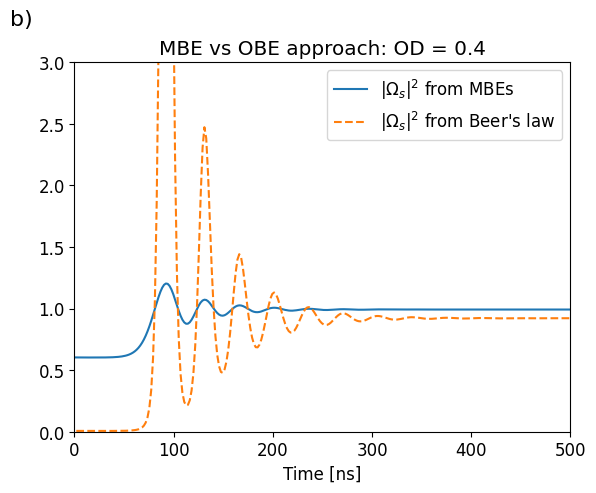

In [35]:
# -------------------------------
# Physical Parameters with higher OD
# ------------------------------- 
GRb = tau*5.8e6 
r = 5e-4
V = (4/3)*np.pi*r**3  # Assume spherical MOT
N_atoms = 2e6
N = N_atoms/V
L = 2*r
kL = L*tau / alib.lambdaRb87_D1 # Propagation factor
PF = N*alib.dRb**2/(alib.hbar*alib.epsilon0)  # Prefactor
eta = PF * (np.pi / alib.lambdaRb87_D1) / GRb  # Coupling strength for MBEs
L0 = Gamma/eta # This sets eta = 1 in dimensionless units, i.e. L0 is the characteristic length scale (OD = 1 at z = L0)
gamma0 = 0.3*Gamma

Omega_s0 = 1e-3
Omega_c0 = 10

# -------------------------------
# Initialization
# -------------------------------

# Define space-time grid
Nz = 200                  # Number of spatial steps
Nt = 750                  # Number of time steps

Z_max = L/L0  # Maximum length in dimensionless units
T_max = 50

rho0 = 0.95*s11 + 0.05*s22  # Initial state: atoms in equal superposition of ground states

# Define space-time grid
z = np.linspace(0, Z_max, Nz)
t = np.linspace(0, T_max, Nt)
dz = z[1] - z[0]
dt = t[1] - t[0]


Rabi_out = solve_MBEs_EIT(t,z,Omega_c0, Omega_s0)
rho_13_out = solve_OBEs_EIT(Omega_s_func(t,Omega_s0), Omega_c_func(t,Omega_c0), delta = 0, t_list = t,gamma = gamma0)
chi = PF*rho_13_out/(GRb*Omega_s_func(t))  # Non-dimensional susceptibility
print(np.abs(chi.max()))
n_idx = 1 + chi/2
OD = np.imag(n_idx)*kL  # Optical depth

OD = np.maximum(OD,-5)  # Set the optical depth to a maximum of 5, i.e. no more than 5 OD

Rabi_OBEs = Omega_s0*np.exp(-OD)  # Propagate the Rabi frequency via the index of refraction

t_ns = t*1e9/alib.GammaRb


# idx_v = np.where(t_n_vaccaro>=200)[0][0]
idx_h = np.where(t_ns>=200)[0][0]
# ODres_v = -2*np.log10(np.abs(Rabi_out_vaccaro[idx_v])**2)
ODres_h = -2*np.log10(np.abs(Rabi_out[idx_h]/Omega_s0)**2)
# print(f'Vacarro Resonant OD: {round(ODres_v,2)}, peak tranny: {100*np.exp(-ODres_v)}%, {np.abs(Rabi_out_vaccaro[idx_v])}')
# print(f'Higher Resonant OD: {round(ODres_h,2)}, peak tranny: {100*np.exp(-ODres_h)}%, ')

# print(f'Peak Gain from OBEs: {np.amax(np.abs(Rabi_OBEs/Omega_s0)**2)}')
# print(f'Peak Gain from MBEs: {np.amax(np.abs(Rabi_out/Omega_s0)**2)}')

plt.rcParams['font.size'] = '12'
# fig,(ax_vaccaro,ax_highgain) = plt.subplots(1,2, figsize=(12, 4))
fig,ax = plt.subplots()


ax.plot(t_ns-200, np.abs(Rabi_out/Omega_s0)**2, label='$\\vert\\Omega_s\\vert^2$ from MBEs')
ax.plot(t_ns-200, np.abs(Rabi_OBEs/Omega_s0)**2,'--', label='$\\vert\\Omega_s\\vert^2$ from Beer\'s law')

ax.legend()

ax.set_xlim([0, 500])
ax.set_ylim([0, 3])


ax.set_title(f'MBE vs OBE approach: OD = {round(ODres_h,1)}')
ax.set_xlabel('Time [ns]')

ax.text(-65,3.3,'b)',fontsize = 16)